In [1]:
# ─── 1) Setup del entorno ─────────────────────────────────────────────────────
import sys
from pathlib import Path
import pandas as pd
import yaml

# 1.a) Ubicamos la carpeta del notebook (notebooks/) y subimos a la raíz del proyecto
notebook_folder = Path().resolve().parent
project_root    = notebook_folder  # si tu notebook está en notebooks/, su padre es la raíz
# si notebook está en otro subdirectorio, ajusta con .parent.parent

# 1.b) Aseguramos que src/ esté en el PYTHONPATH para importar utils o src modules
src_folder = project_root / "src"
if str(src_folder) not in sys.path:
    sys.path.insert(0, str(src_folder))

# ─── 2) Cargar configuración ──────────────────────────────────────────────────
from utils import load_config
config = load_config()  # busca project_root/config/config.yaml

# ─── 3) Construir rutas absolutas a Parquet ───────────────────────────────────
# Los config deben tener algo así:
# config['randomforest']['features_path']         = "data/processed/features_... .parquet"
# config['randomforest']['export_signals_path']   = "data/processed/signals_... .parquet"

features_rel = config['randomforest']['features_path']
signals_rel  = config['randomforest']['export_signals_path']

features_path = project_root / features_rel
signals_path  = project_root / signals_rel

# 3.b) Validar existencia
if not features_path.exists():
    raise FileNotFoundError(f"No existe el fichero de features: {features_path}")
if not signals_path.exists():
    raise FileNotFoundError(f"No existe el fichero de signals:  {signals_path}")

# ─── 4) Leer los datos ─────────────────────────────────────────────────────────
features = pd.read_parquet(features_path)
signals  = pd.read_parquet(signals_path)['signal']

2025-07-08 00:41:42,320 - utils - INFO - Configuración cargada exitosamente desde: C:\Users\DELL-LATITUDE\Documents\My_Projects\PYTHON\trading_quantitative\config\config.yaml


In [2]:
from backtest import BacktestEngine
# Asegurar alineación temporal
features = features.loc[signals.index]

# 3. Instanciar motor de backtesting con configuración
engine = BacktestEngine(config)

# 4. Ejecutar backtest con tamaño de posición 10%
results = engine.run_backtest(features, signals, position_size=0.1)

# 5. Mostrar métricas de rendimiento
metrics = engine.get_performance_metrics(results)
print("Métricas de rendimiento:")
for k, v in metrics.items():
    print(f"{k}: {v}")


2025-07-08 00:41:42,976 - BacktestEngine - INFO - Iniciando backtesting...
2025-07-08 00:41:43,148 - BacktestEngine - INFO - Backtesting completado. Operaciones: 2258


Métricas de rendimiento:
total_trades: 2258
winning_trades: 672
losing_trades: 1586
win_rate: 29.760850310008856
total_return: -36.71334095574862
cagr: -60.27565547231245
max_drawdown: -86.79524596176348
sharpe_ratio: 1.17659945637709
sortino_ratio: 123.3685446735349
profit_factor: 0.4519409019210656
initial_capital: 10000
final_capital: 6328.665904425138
mean_return_ci_95: (np.float64(0.012546277131684684), np.float64(0.029414530066772145))


In [3]:
# 6. Realizar análisis Monte Carlo para robustez estadística
mc_results = engine.monte_carlo_analysis(results, n_sim=1000)
print("\nIntervalo de confianza 95% para capital final (Monte Carlo):")
print(mc_results['final_equity_ci_95'])


Intervalo de confianza 95% para capital final (Monte Carlo):
[3.94000509e-11 1.19097832e+10]


In [4]:
import plotly.graph_objects as go

# 7. Visualización 1: Graficar curva de equity con drawdowns
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.equity_curve.index, y=results.equity_curve, mode='lines', name='Equity Curve'))
fig.add_trace(go.Scatter(x=results.drawdowns.index, y=results.drawdowns * results.equity_curve, fill='tozeroy', mode='none', name='Drawdown', fillcolor='rgba(255,0,0,0.3)'))
fig.update_layout(title='Equity Curve con Drawdowns', xaxis_title='Fecha', yaxis_title='Capital')
fig.show()


In [5]:
import plotly.express as px

# 8. Visualización 2: Distribución de retornos por trade
trade_returns = [t.return_pct for t in results.trades if not t.is_open]
fig2 = px.histogram(trade_returns, nbins=50, title='Distribución de Retornos por Trade', labels={'value':'Retorno (%)'})
fig2.update_layout(bargap=0.1)
fig2.show()

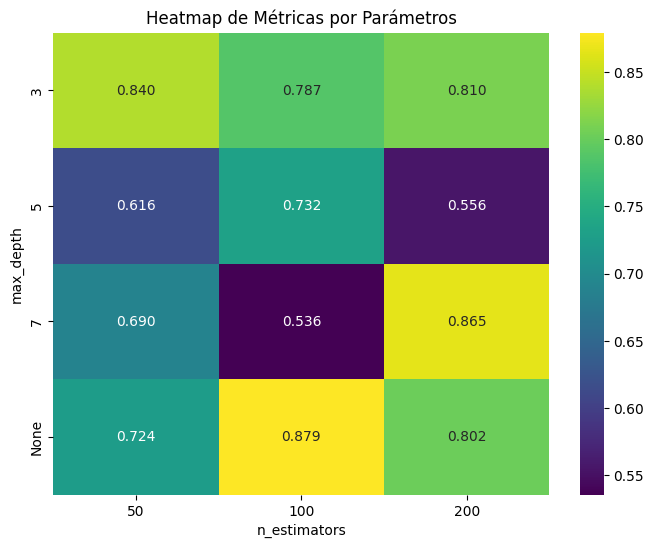

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 9. Visualización 3: Heatmap de métricas por parámetros (Ejemplo con grid_search)
if config['randomforest'].get('grid_search', False):
    param_grid = config['randomforest']['param_grid']
    # Aquí se asume que tienes resultados de grid_search guardados o calculados
    # Para ejemplo, simulo resultados aleatorios para heatmap
    import itertools
    n_estimators = param_grid.get('n_estimators', [100])
    max_depth = param_grid.get('max_depth', [5])
    data_heatmap = []
    for n, d in itertools.product(n_estimators, max_depth):
        # Simular alguna métrica, por ejemplo accuracy o Sharpe Ratio
        metric_val = np.random.uniform(0.5, 0.9)
        data_heatmap.append({'n_estimators': n, 'max_depth': d if d is not None else 'None', 'metric': metric_val})
    df_heatmap = pd.DataFrame(data_heatmap)
    heatmap_data = df_heatmap.pivot(index='max_depth', columns='n_estimators', values='metric')
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Heatmap de Métricas por Parámetros')
    plt.ylabel('max_depth')
    plt.xlabel('n_estimators')
    plt.show()

In [ ]:
# 10. Generar reporte PDF automatizado
# pdf_filename = "backtest_report.pdf"
# engine.generate_pdf_report(results, metrics, filename=pdf_filename)
# print(f"\nReporte PDF generado: {pdf_filename}")

2025-07-08 00:41:44,391 - BacktestEngine - INFO - Reporte PDF generado: backtest_report.pdf



Reporte PDF generado: backtest_report.pdf


In [8]:
# 9. (Opcional) Análisis de estabilidad temporal con walk-forward
walk_metrics = engine._walk_forward_analysis(results.equity_curve, window=30)
print("\nAnálisis walk-forward (retornos y drawdowns por ventana):")
for i, wm in enumerate(walk_metrics):
    print(f"Ventana {i+1}: Retorno={wm['return']:.4f}, Drawdown={wm['drawdown']:.4f}")


Análisis walk-forward (retornos y drawdowns por ventana):
Ventana 1: Retorno=0.0000, Drawdown=0.0000
Ventana 2: Retorno=0.1041, Drawdown=-0.5690
Ventana 3: Retorno=-0.7435, Drawdown=-0.7439
Ventana 4: Retorno=1.0500, Drawdown=-0.8664
Ventana 5: Retorno=-0.0020, Drawdown=-0.2714
Ventana 6: Retorno=-0.0007, Drawdown=-0.5233
Ventana 7: Retorno=0.0999, Drawdown=-0.6165
Ventana 8: Retorno=-0.2755, Drawdown=-0.3369
Ventana 9: Retorno=0.5210, Drawdown=-0.5216
Ventana 10: Retorno=-0.1937, Drawdown=-0.4703
Ventana 11: Retorno=-0.0062, Drawdown=-0.3464
Ventana 12: Retorno=0.1178, Drawdown=-0.4081
Ventana 13: Retorno=-0.0072, Drawdown=-0.4101
Ventana 14: Retorno=0.1110, Drawdown=-0.3446
Ventana 15: Retorno=-0.2730, Drawdown=-0.4109
Ventana 16: Retorno=0.2311, Drawdown=-0.4681
Ventana 17: Retorno=-0.0100, Drawdown=-0.4122
Ventana 18: Retorno=0.0039, Drawdown=-0.6810
Ventana 19: Retorno=-0.3423, Drawdown=-0.4083
Ventana 20: Retorno=0.5214, Drawdown=-0.6125
Ventana 21: Retorno=-0.1919, Drawdown=-0.